In [ ]:
from google.colab import drive
drive.mount('/content/drive')


FOLDERNAME = 'CS231N'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
from time import time
from os import path
from torchvision import transforms
import random
from copy import deepcopy
import urllib.request
import ssl
import tarfile

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
from sklearn.metrics import balanced_accuracy_score


USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print('using device:', device)

using device: cpu


In [ ]:
gcontext = ssl.SSLContext()
dataseturl = "https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz"
fstream = urllib.request.urlopen(dataseturl, context=gcontext)
tarfile = tarfile.open(fileobj=fstream, mode="r:gz")
tarfile.extractall()

<ipython-input-3-70fa6fd4157e>:1: DeprecationWarning: ssl.SSLContext() without protocol argument is deprecated.
  gcontext = ssl.SSLContext()
<ipython-input-3-70fa6fd4157e>:1: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  gcontext = ssl.SSLContext()


this is table 4524
Index(['participant_id', 'session_id', 'alternative_id_1', 'sex',
       'education_level', 'age_bl', 'cdr', 'diagnosis_bl', 'laterality', 'MMS',
       'cdr_global', 'diagnosis'],
      dtype='object')


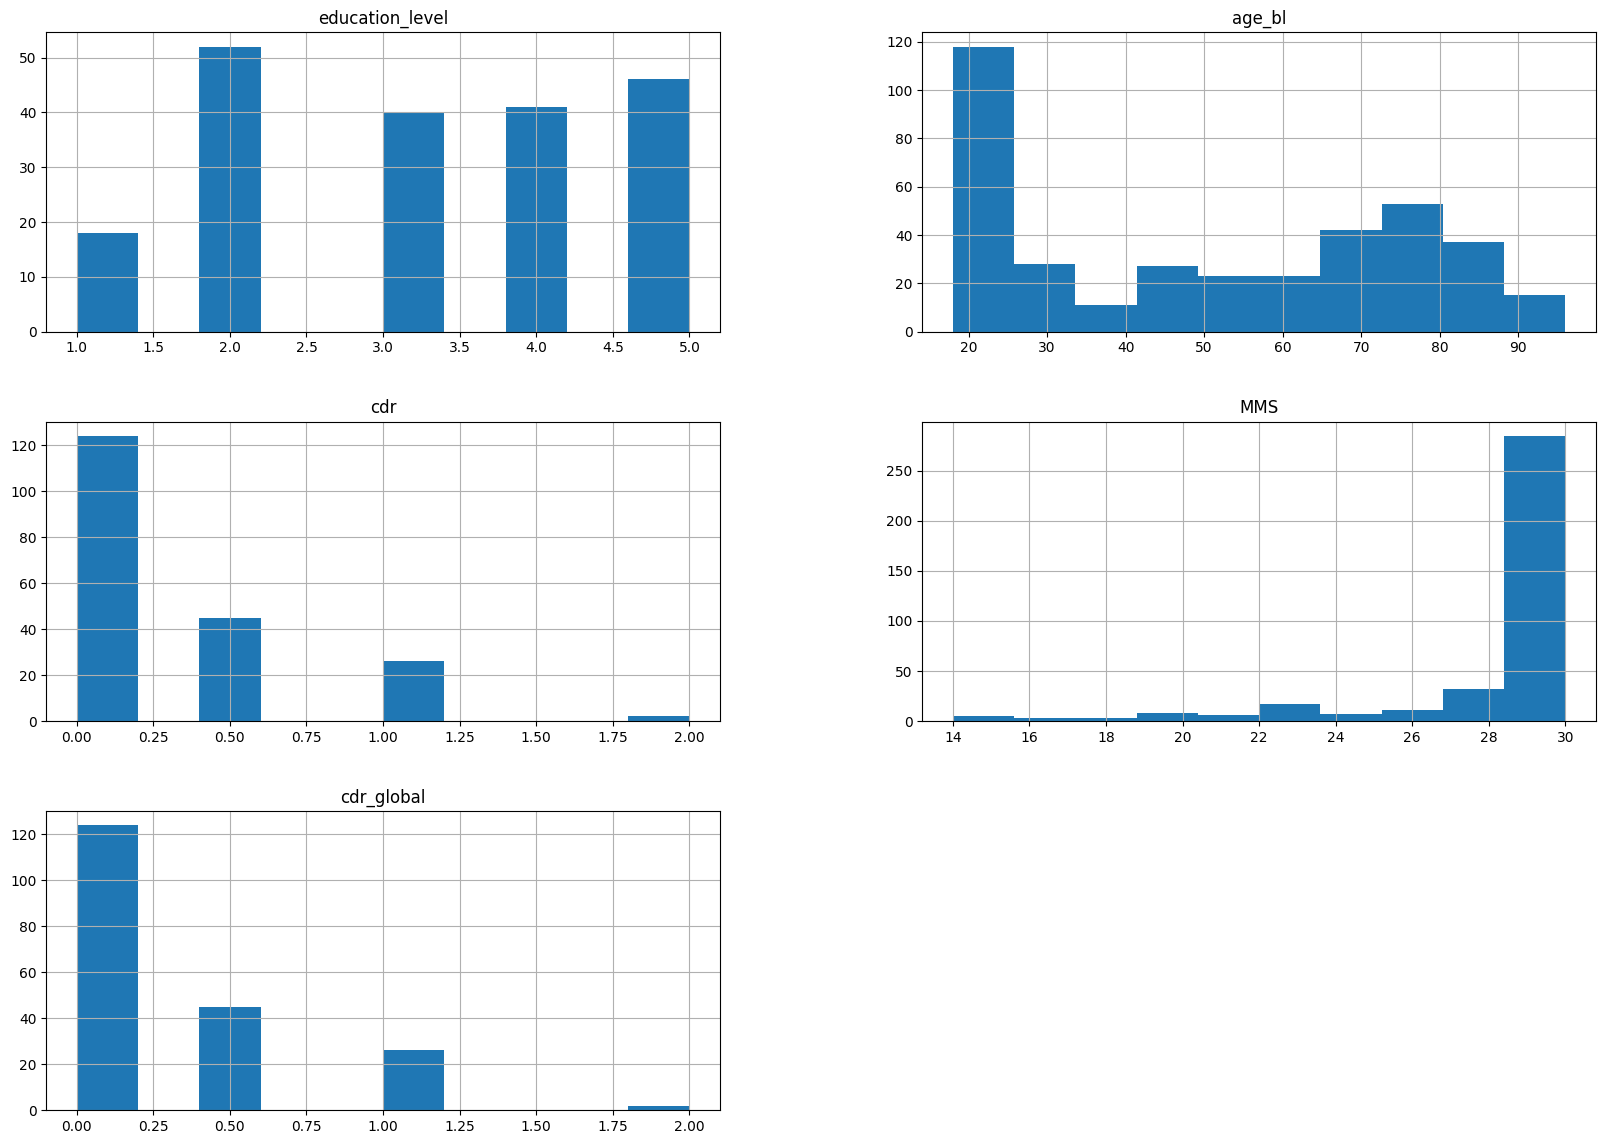

In [ ]:
# Load the complete dataset
OASIS_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv', sep='\t')
print("this is table", OASIS_df.size)
# Show first items of the table
print(OASIS_df.columns)
# First visual inspection
_ = OASIS_df.hist(figsize=(20, 14))

Show the slices of image

(256, 256, 160)


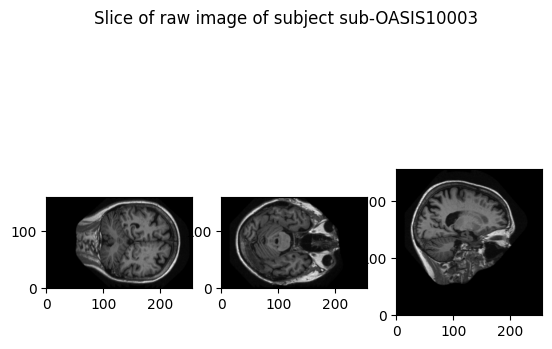

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import rotate

subject = 'sub-OASIS10003'
preprocessed_pt = torch.load(f'OASIS-1_dataset/CAPS/subjects/{subject}/ses-M00/' +
                    f'deeplearning_prepare_data/image_based/custom/{subject}_ses-M00_' +
                    'T1w_segm-graymatter_space-Ixi549Space_modulated-off_' +
                    'probability.pt')
raw_nii = nib.load(f'OASIS-1_dataset/raw/{subject}_ses-M00_T1w.nii.gz')

raw_np = raw_nii.get_fdata()

def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
print(raw_np.shape)
slice_0 = raw_np[80, :, :]
slice_1 = raw_np[:, 130, :]
slice_2 = raw_np[:, :, 60]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Slice of raw image of subject {subject}')
plt.show()

Define torch dataset to load MRI images and their labels in OASIS_BIDS.tsv



In [ ]:
from torch.utils.data import Dataset, DataLoader, sampler
from os import path
import torchvision.transforms as transforms

LABEL_NAMES = {"AD": 1, "CN": 0}
class MRIDataset(Dataset):
    def __init__(self, image_path, dataframe, data_transforms=None):
        """
        Args:
          dataframe (string): Path to the OASIS_tsv file.
          image_path (string): Directory with all the images.
          transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = dataframe
        self.image_path = image_path
        self.data_transforms = data_transforms

    def __len__(self):
        """
        return the size of dataset
        """
        return len(self.dataframe)



    def __getitem__(self, idx):
        """
        return a tuple: (image, label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #get participant_id and session_id
        participant_id = self.dataframe.loc[idx, 'participant_id']
        session_id = self.dataframe.loc[idx, 'session_id']
        # print(idx)
        # print("this is current image", participant_id)

        #get image
        filename = 'subjects/' + participant_id + '/' + session_id + '/' + \
          'deeplearning_prepare_data/image_based/custom/' + \
          participant_id + '_' + session_id + \
          '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'
        image = torch.load(path.join(self.image_path, filename))

        #get label and convert it into binary
        image_label = self.dataframe.loc[idx, 'diagnosis']
        label = LABEL_NAMES[image_label]

        #return a list of 2d images
        transformed_slices = []
        if self.data_transforms:
            transformed_slices = self.data_transforms(image)
            data_samples = [(tran_slice, label) for tran_slice in transformed_slices]
            return data_samples

        image_map = (image, label)
        return image_map

    def train(self):
        self.data_transforms.train()

    def eval(self):
        self.data_transforms.eval()

this is original image shape torch.Size([1, 121, 145, 121])
this is center_slice shape torch.Size([1, 121, 121])

In [ ]:
class SelectImageSlices(object):
    """Selects slices from a 3D MRI volume along the z-axis"""
    def __init__(self, num_slices=10):
        self.num_slices = num_slices

    def __call__(self, img):
        # Assuming img is a 3D numpy array of shape (256, 256, 160)
        z_center = img.shape[3] // 2  # Calculate the center along the z-axis

        # Select slices around the center along the z-axis
        start_slice = max(0, z_center - self.num_slices // 2)
        end_slice = min(img.shape[3], start_slice + self.num_slices)
        print("this is image shape", img.shape)

        selected_slices = img[:, :, :, start_slice:end_slice]

        # Create a list to store the centered slices
        centered_slices = []
        show_list = []
        print("this is original image shape", img.shape)

        # Iterate over selected slices and center each slice
        for i in range(selected_slices.shape[3]):
            # Get the center slice from each selected slice
            center_slice = selected_slices[:, :,:, i]
            print("this is shape after slice", center_slice.shape)
            numpy_array = center_slice.numpy()
            show_list.append(numpy_array)
            # Append the centered slice to the list
            centered_slices.append(center_slice)
        show_slices(show_list)
        return centered_slices

0
this is current image sub-OASIS10001
this is image shape torch.Size([1, 121, 145, 121])
this is original image shape torch.Size([1, 121, 145, 121])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slice torch.Size([1, 121, 145])
1
this is current image sub-OASIS10002
this is image shape torch.Size([1, 121, 145, 121])
this is original image shape torch.Size([1, 121, 145, 121])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slice torch.Size([1, 121, 145])
this is shape after slic

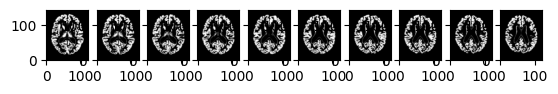

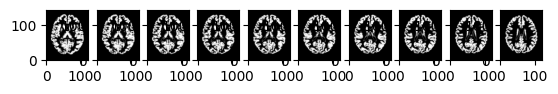

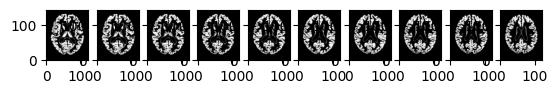

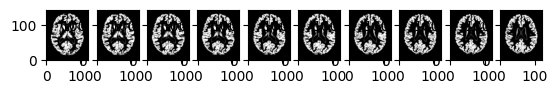

In [ ]:
#Can use this cell to visualize the slice
img_dir = path.join('OASIS-1_dataset', 'CAPS')

example_dataset = MRIDataset(img_dir, OASIS_df, data_transforms = SelectImageSlices())
#example_dataset = MRIDataset(img_dir, OASIS_df, data_transforms=None)
example_dataloader = DataLoader(example_dataset, batch_size=4, drop_last=True)

for batch_idx, data_list in enumerate(example_dataloader):
    if batch_idx == 0:  # Check if it's the first three batches
      print(len(data_list))
      break
#       for data in data_list:
#         images, labels = data
#         sliced_tensors = [images[i].numpy() for i in range(images.size(0))]
#         show_list.append(sliced_tensors)
#         # print("Batch:", batch_idx)
#         #print("Image sizes:", images.size())

print(f"Shape of Dataset output:\n {len(example_dataloader)}\n")
